In [ ]:
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# dataset import
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ML
data = pd.read_csv('pm_data.csv')
data.columns = ['No', 'year', 'month', 'day', 'hour', 'concentration', 'dew_point', 'temperature', 'pressure', 'wind_direction', 'wind_speed', 'snow_hours', 'rain_hours']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ML


# EDA and Preprocessing

In [ ]:
# details about the data
print(data)
data.info()
data.describe()

          No  year  month  ...  wind_speed  snow_hours  rain_hours
0          1  2010      1  ...        1.79           0           0
1          2  2010      1  ...        4.92           0           0
2          3  2010      1  ...        6.71           0           0
3          4  2010      1  ...        9.84           0           0
4          5  2010      1  ...       12.97           0           0
...      ...   ...    ...  ...         ...         ...         ...
43819  43820  2014     12  ...      231.97           0           0
43820  43821  2014     12  ...      237.78           0           0
43821  43822  2014     12  ...      242.70           0           0
43822  43823  2014     12  ...      246.72           0           0
43823  43824  2014     12  ...      249.85           0           0

[43824 rows x 13 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------    

,No,year,month,day,hour,concentration,dew_point,temperature,pressure,wind_speed,snow_hours,rain_hours
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [ ]:
# removing No column
data = data.drop(['No'], axis = 1)

print('Count of duplicate values:\n', data.duplicated().sum(), '\n')
print('Count of null values\n', data.isna().sum(), '\n')
print('Count by month\n', data['month'].groupby(data['month']).count())

Count of duplicate values:
 0 

Count of null values
 year                 0
month                0
day                  0
hour                 0
concentration     2067
dew_point            0
temperature          0
pressure             0
wind_direction       0
wind_speed           0
snow_hours           0
rain_hours           0
dtype: int64 

Count by month
 month
1     3720
2     3384
3     3720
4     3600
5     3720
6     3600
7     3720
8     3720
9     3600
10    3720
11    3600
12    3720
Name: month, dtype: int64


In [ ]:
# removing null values
data.dropna(inplace=True)
print('Count of null values\n', data.isna().sum(), '\n')

Count of null values
 year              0
month             0
day               0
hour              0
concentration     0
dew_point         0
temperature       0
pressure          0
wind_direction    0
wind_speed        0
snow_hours        0
rain_hours        0
dtype: int64 



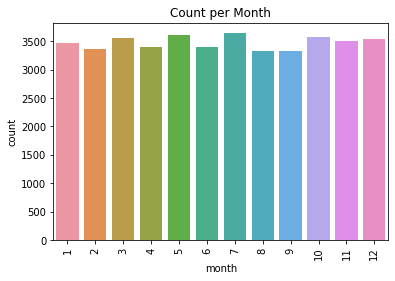

In [ ]:
# distribution by month
plt.title('Count per Month')
sns.countplot(x = data.month)
plt.xticks(rotation=90)
plt.show()

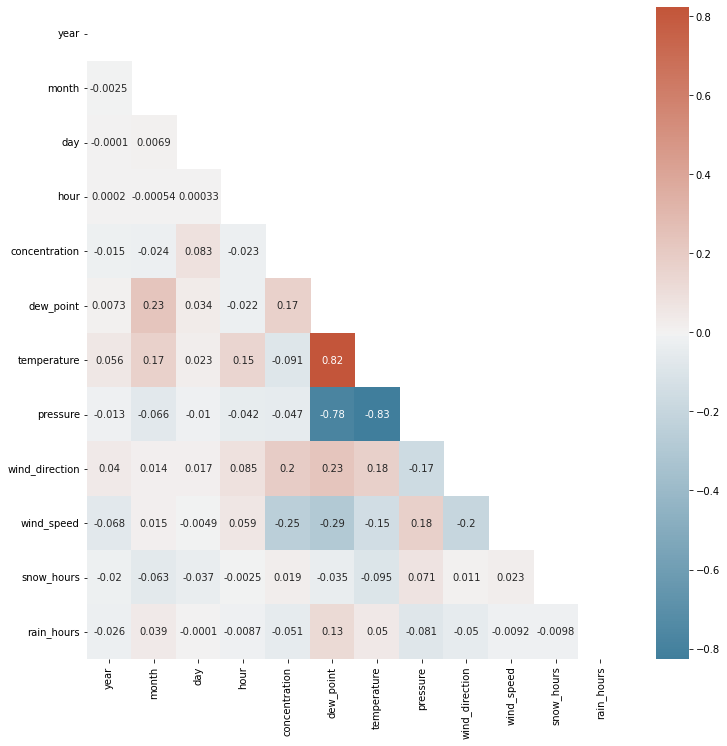

In [ ]:
# checking correlation between features
corr = data.corr()
plt.figure(figsize=(12, 12))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

In [ ]:
# distinct elements in wind direction
print('Wind directions: ', data.wind_direction.unique())
print('Count by wind direction\n', data['wind_direction'].groupby(data['wind_direction']).count())

# pre-processing to convert Wind direction column values {'NE', 'NW', 'SE', 'cv'} to integers {0, 1, 2, 3}
convert = {'wind_direction': {'NE':0, 'NW':1, 'SE':2, 'cv':3}}
data = data.replace(convert)

Wind directions:  ['SE' 'cv' 'NW' 'NE']
Count by wind direction
 wind_direction
NE     4756
NW    13484
SE    14573
cv     8944
Name: wind_direction, dtype: int64


In [ ]:
# splitting data into test and train datasets
def split_train_test(input, output, train_ratio=0.8):
    X_train = []
    Y_train = []
    X_test = input.tolist()
    Y_test = output.tolist()
    train_size = math.floor(train_ratio * len(input))
    
    while len(X_train) < train_size:
        index = random.randint(0, len(X_test)-1)
        X_train.append(X_test.pop(index))
        Y_train.append(Y_test.pop(index))
    
    return X_train, X_test, Y_train, Y_test

# separating input and output features
output = data['month']
input = data.drop('month', axis='columns')

input = input.to_numpy()
output = output.to_numpy()

# splitting data into train, validation and test datasets
random.seed(0)
x_train, x_test, y_train, y_test = split_train_test(input, output, 0.85)
x_train, x_val, y_train, y_val = split_train_test(np.array(x_train), np.array(y_train), 0.82)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_val = np.array(x_val)
y_val = np.array(y_val)

y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))
y_val = np.reshape(y_val, (y_val.shape[0], 1))

# Decision Trees and Random Forests

In [ ]:
# calculate accuracy
def calc_accuracy(y_pred, y_test):
    ctr = 0
    for i in range(len(y_test)):
        if y_pred[i] == y_test[i]:
            ctr += 1
    accuracy = ctr/len(y_test)
    return accuracy

In [ ]:
# default values
# splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0
# max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0

from sklearn.tree import DecisionTreeClassifier

# gini
dtc = DecisionTreeClassifier(random_state=0, criterion='gini')
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
print('Accuracy: ', calc_accuracy(y_pred, y_test))

Accuracy:  0.8218390804597702


In [ ]:
# entropy
dtc = DecisionTreeClassifier(random_state=0, criterion='entropy')
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
print('Accuracy: ', calc_accuracy(y_pred, y_test))

Accuracy:  0.8405172413793104


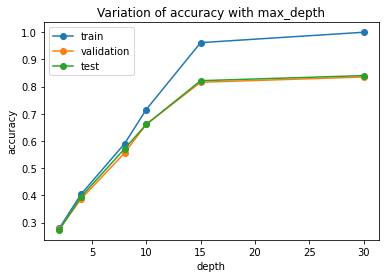

Train scores:  [0.27889637163276526, 0.4039994502473887, 0.5898158328752061, 0.715743540406817, 0.9617578339747114, 1.0]
Validation scores:  [0.2762560651119111, 0.38660197213961495, 0.5557990295820943, 0.6611363280638598, 0.8159336359367663, 0.8353419940522774]
Test scores:  [0.27282886334610473, 0.39479565772669223, 0.5710408684546615, 0.6609195402298851, 0.8218390804597702, 0.8405172413793104]


In [ ]:
# variation of accuracy with max_depth of decision tree
depth_range = [2, 4, 8, 10, 15, 30]
train_score = []
val_score = []
test_score = []
for x in depth_range:
    dtc = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=x)
    dtc.fit(x_train, y_train)
    train_score.append(calc_accuracy(dtc.predict(x_train), y_train))
    val_score.append(calc_accuracy(dtc.predict(x_val), y_val))
    test_score.append(calc_accuracy(dtc.predict(x_test), y_test))
plt.plot(depth_range, train_score, label='train', marker='o')
plt.plot(depth_range, val_score, label='validation', marker='o')
plt.plot(depth_range, test_score, label='test', marker='o')
plt.title('Variation of accuracy with max_depth')
plt.xlabel('depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()
print('Train scores: ', train_score)
print('Validation scores: ', val_score)
print('Test scores: ', test_score)

In [ ]:
# ensemble of decision stumps
def ensemble(depth, num_estimators, x_test, y_test):
    votes = []
    random.seed(0)
    for i in range(num_estimators):
        # randomly selecting 50% of training data
        x, x2, y, y2 = split_train_test(np.array(x_train), np.array(y_train), 0.5)
        dtc = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=depth)
        dtc.fit(x, y)
        y_pred = dtc.predict(x_test)
        votes.append(y_pred)
    votes = np.array(votes)

    # finding the majority vote
    max_voted = []
    for i in range(votes.shape[1]):
        maxval = np.bincount(votes[:, i]).argmax()
        max_voted.append(maxval)
    max_voted = np.array(max_voted)
    accuracy = calc_accuracy(max_voted, y_test)
    return accuracy

# ensemble of 100 decision stumps of max_depth 3
accuracy = ensemble(3, 100, x_test, y_test)
print('Accuracy for max_depth on testing data', 3, ': ', accuracy)
accuracy = ensemble(3, 100, x_train, y_train)
print('Accuracy for max_depth on training data', 3, ': ', accuracy)

Accuracy for max_depth on testing data 3 :  0.35727969348659006
Accuracy for max_depth on training data 3 :  0.357957669048928


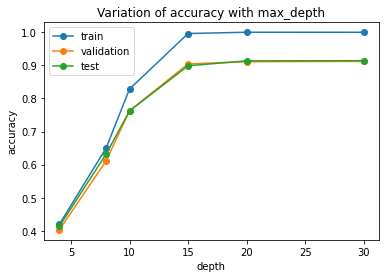

Train scores:  [0.41939252336448596, 0.6502542605827377, 0.8280992303463441, 0.9958081363386476, 0.9996564046179219, 0.9995533260032985]
Validation scores:  [0.4028799499139145, 0.6113632806385976, 0.7628736891532322, 0.9040538425418688, 0.9106276412584129, 0.9118797933948974]
Test scores:  [0.41347381864623245, 0.6318646232439336, 0.7619731800766284, 0.8984674329501916, 0.9133141762452107, 0.9137931034482759]
Test Accuracy:  0.9137931034482759
Train Accuracy:  0.9996564046179219


In [ ]:
# variation of ensemble accuracy with max_depth
depth_range = [4, 8, 10, 15, 20, 30]
train_score = []
val_score = []
test_score = []
num_estimators = 100
for depth in depth_range:
    train_score.append(ensemble(depth, num_estimators, x_train, y_train))
    val_score.append(ensemble(depth, num_estimators, x_val, y_val))
    test_score.append(ensemble(depth, num_estimators, x_test, y_test))

plt.plot(depth_range, train_score, label='train', marker='o')
plt.plot(depth_range, val_score, label='validation', marker='o')
plt.plot(depth_range, test_score, label='test', marker='o')
plt.title('Variation of accuracy with max_depth')
plt.xlabel('depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()
print('Train scores: ', train_score)
print('Validation scores: ', val_score)
print('Test scores: ', test_score)
print('Test Accuracy: ', max(test_score))
print('Train Accuracy: ', max(train_score))

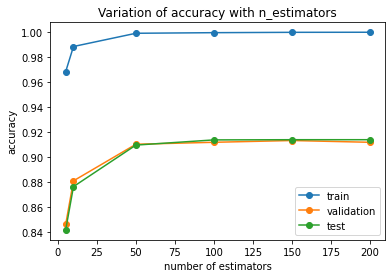

Train scores:  [0.9683548653106102, 0.9884895547003848, 0.9990722924683892, 0.9995533260032985, 0.999828202308961, 0.9998969213853766]
Validation scores:  [0.8461418062294569, 0.8810455470339646, 0.9103146032242917, 0.9118797933948974, 0.9132884645484426, 0.9118797933948974]
Test scores:  [0.841794380587484, 0.8764367816091954, 0.9096424010217113, 0.9137931034482759, 0.9139527458492975, 0.9139527458492975]
Test Accuracy:  0.9139527458492975
Train Accuracy:  0.9998969213853766


In [ ]:
# variation of ensemble accuracy with n_estimators
n_estimators_range = [5, 10, 50, 100, 150, 200]
train_score = []
val_score = []
test_score = []
depth = 30
for n in n_estimators_range:
    train_score.append(ensemble(depth, n, x_train, y_train))
    val_score.append(ensemble(depth, n, x_val, y_val))
    test_score.append(ensemble(depth, n, x_test, y_test))

plt.plot(n_estimators_range, train_score, label='train', marker='o')
plt.plot(n_estimators_range, val_score, label='validation', marker='o')
plt.plot(n_estimators_range, test_score, label='test', marker='o')
plt.title('Variation of accuracy with n_estimators')
plt.xlabel('number of estimators')
plt.ylabel('accuracy')
plt.legend()
plt.show()
print('Train scores: ', train_score)
print('Validation scores: ', val_score)
print('Test scores: ', test_score)
print('Test Accuracy: ', max(test_score))
print('Train Accuracy: ', max(train_score))

Test accuracy of default AdaBoost Classifier:  0.25223499361430396


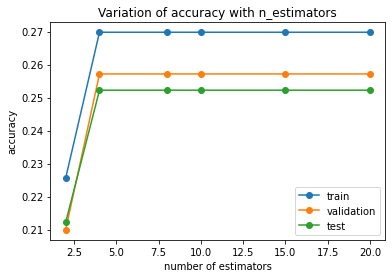

Train scores:  [0.2256047278724574, 0.2697910940076965, 0.2697910940076965, 0.2697910940076965, 0.2697910940076965, 0.2697910940076965]
Validation scores:  [0.2098920018782282, 0.2571607450305212, 0.2571607450305212, 0.2571607450305212, 0.2571607450305212, 0.2571607450305212]
Test scores:  [0.21216475095785442, 0.25223499361430396, 0.25223499361430396, 0.25223499361430396, 0.25223499361430396, 0.25223499361430396]
Max test accuracy:  0.25223499361430396
Max train accuracy:  0.2697910940076965


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# accuracy of adaboost classifier on test data

# default estimator: Decision Tree Classifier with max_depth 1
# default number of estimators=50
abc = AdaBoostClassifier(random_state=0, base_estimator=DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=1))
abc.fit(x_train, np.ravel(y_train))
print('Test accuracy of default AdaBoost Classifier: ', calc_accuracy(abc.predict(x_test), y_test))

# variation of adaboost classifier accuracy with number of estimators

n_estimators_range = [2, 4, 8, 10, 15, 20]
train_score = []
val_score = []
test_score = []
for x in n_estimators_range:
    abc = AdaBoostClassifier(random_state=0, base_estimator=DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=1), n_estimators=x)    
    abc.fit(x_train, np.ravel(y_train))
    train_score.append(calc_accuracy(abc.predict(x_train), y_train))
    val_score.append(calc_accuracy(abc.predict(x_val), y_val))
    test_score.append(calc_accuracy(abc.predict(x_test), y_test))
plt.plot(n_estimators_range, train_score, label='train', marker='o')
plt.plot(n_estimators_range, val_score, label='validation', marker='o')
plt.plot(n_estimators_range, test_score, label='test', marker='o')
plt.title('Variation of accuracy with n_estimators')
plt.xlabel('number of estimators')
plt.ylabel('accuracy')
plt.legend()
plt.show()
print('Train scores: ', train_score)
print('Validation scores: ', val_score)
print('Test scores: ', test_score)
print('Max test accuracy: ', max(test_score))
print('Max train accuracy: ', max(train_score))


Test accuracy of default AdaBoost Classifier:  0.25223499361430396


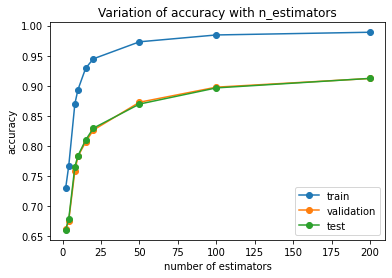

Train scores:  [0.7303119846069269, 0.7670766904892798, 0.8704645409565696, 0.8936915887850467, 0.9292193512919187, 0.9448529411764706, 0.9730964815832875, 0.9844694887300715, 0.9889705882352942]
Validation scores:  [0.6617624041321021, 0.6763186727187354, 0.7589607137267178, 0.783064642354046, 0.8066990139301925, 0.8265769290968853, 0.8727500391297542, 0.897793081859446, 0.9121928314290186]
Test scores:  [0.6607598978288634, 0.6789591315453385, 0.7659642401021711, 0.7840038314176245, 0.8100255427841635, 0.829661558109834, 0.8697318007662835, 0.896551724137931, 0.9123563218390804]
Max test accuracy:  0.9123563218390804
Max train accuracy:  0.9889705882352942


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# accuracy of adaboost classifier on test data

# default estimator: Decision Tree Classifier with max_depth 1
# default number of estimators=50
abc = AdaBoostClassifier(random_state=0, base_estimator=DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=1))
abc.fit(x_train, np.ravel(y_train))
print('Test accuracy of default AdaBoost Classifier: ', calc_accuracy(abc.predict(x_test), y_test))

# variation of adaboost classifier accuracy with number of estimators

n_estimators_range = [2, 4, 8, 10, 15, 20, 50, 100, 200]
train_score = []
val_score = []
test_score = []
for x in n_estimators_range:
    abc = AdaBoostClassifier(random_state=0, base_estimator=DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=10), n_estimators=x)    
    abc.fit(x_train, np.ravel(y_train))
    train_score.append(calc_accuracy(abc.predict(x_train), y_train))
    val_score.append(calc_accuracy(abc.predict(x_val), y_val))
    test_score.append(calc_accuracy(abc.predict(x_test), y_test))
plt.plot(n_estimators_range, train_score, label='train', marker='o')
plt.plot(n_estimators_range, val_score, label='validation', marker='o')
plt.plot(n_estimators_range, test_score, label='test', marker='o')
plt.title('Variation of accuracy with n_estimators')
plt.xlabel('number of estimators')
plt.ylabel('accuracy')
plt.legend()
plt.show()
print('Train scores: ', train_score)
print('Validation scores: ', val_score)
print('Test scores: ', test_score)
print('Max test accuracy: ', max(test_score))
print('Max train accuracy: ', max(train_score))
